In [1]:
%matplotlib inline
from vnpy.trader.vtObject import VtBarData
from vnpy.trader.vtConstant import EMPTY_STRING
from vnpy.trader.app.ctaStrategy.ctaBase import TICK_DB_NAME
from datetime import datetime, time
from vnpy.trader.app.ctaStrategy.ctaBacktesting import BacktestingEngine
from vnpy.trader.app.ctaStrategy.ctaTemplate import (CtaTemplate, 
                                                     BarManager, 
                                                     ArrayManager)

In [2]:
#合约代码
code = 'rb1805'
exchange = 'SHFE'
vtCode = '.'.join([code, exchange])
startDate = '20170516'
endDate = datetime.now().strftime('%Y%m%d')
#endDate = '20170601'

In [5]:
'''
我的策略
'''
class TestStrategy(CtaTemplate):
    """结合ATR和RSI指标的一个分钟线交易策略"""
    className = 'TestStrategy'
    author = u'loe'

    # 策略参数
    atrLength = 6           # 计算ATR指标的窗口数   
    atrMaLength = 10        # 计算ATR均线的窗口数
    trailingPercent = 0.8   # 百分比移动止损
    initDays = 26           # 初始化数据所用的天数
    fixedSize = 1           # 每次交易的数量

    # 策略变量
    atrValue = 0                        # 最新的ATR指标数值
    atrMa = 0                           # ATR移动平均的数值
    lastBar = None                      # 分钟k线合成的日k线

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        """Constructor"""
        super(TestStrategy, self).__init__(ctaEngine, setting)
        
        # 创建K线合成器对象
        self.bm = BarManager(self.onBar, )
        self.am = ArrayManager(size = 20)
        self.newBar = True
        
        # 注意策略类中的可变对象属性（通常是list和dict等），在策略初始化时需要重新创建，
        # 否则会出现多个策略实例之间数据共享的情况，有可能导致潜在的策略逻辑错误风险，
        # 策略类中的这些可变对象属性可以选择不写，全都放在__init__下面，写主要是为了阅读
        # 策略时方便（更多是个编程习惯的选择）        

    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略（必须由用户继承实现）"""
        self.writeCtaLog(u'%s策略初始化' %self.name)
        
        # 载入历史数据，并采用回放计算的方式初始化策略数值
        initData = self.loadBar(self.initDays)
        for tick in initData:
            self.onTick(tick)

        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'%s策略启动' %self.name)
        self.putEvent()

    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略（必须由用户继承实现）"""
        self.writeCtaLog(u'%s策略停止' %self.name)
        self.putEvent()

    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送（必须由用户继承实现）"""
        self.bm.updateTick(tick)
        #print tick.datetime, ' '*2, tick.lastPrice

    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送（必须由用户继承实现）"""
        #self.cancelAll()
        
        newBar = False
        
        if (not self.lastBar) or (self.lastBar.datetime.date() != bar.datetime.date()):
            if self.lastBar:
                #self.lastBar.datetime = self.lastBar.datetime.replace(hour=0, minute=0, second=0, microsecond=0)  # 将时分秒微秒设为0
                # 保存K线数据
                self.am.updateBar(self.lastBar)
                #'''
                print '='*26, self.lastBar.datetime, '='*26
            
                print 'open', ' '*2, self.lastBar.open
                print 'close', ' '*2, self.lastBar.close
                print 'high', ' '*2, self.lastBar.high
                print 'low', ' '*2, self.lastBar.low, '\n'
                #'''
            newBar = True
            
        if newBar:
            self.lastBar = VtBarData()
            self.lastBar.open = bar.open
            self.lastBar.high = bar.high
            self.lastBar.low = bar.low
        else:
            self.lastBar.high = max(self.lastBar.high, bar.high)
            self.lastBar.low = min(self.lastBar.low, bar.low)
        
        self.lastBar.datetime = bar.datetime
        self.lastBar.close = bar.close
        
        if not self.am.inited:
            return

        # 计算指标数值
        atrList = self.am.atr(self.atrLength, array=True)
        self.atrValue = atrList[-1]
        #self.atrValue = self.am.atr(self.atrLength)
        
        '''
        if self.trading:
            print '='*26, bar.datetime, '='*26
            
            print 'hightList'
            print self.am.high
            
            print 'lowList'
            print self.am.low
            
            print 'closeList'
            print self.am.close
            
            print 'atrList'
            print atrList
            
            print 'atrValue', ' '*2, self.atrValue, '\n'
        '''

    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        pass

    #----------------------------------------------------------------------
    def onTrade(self, trade):
        # 发出状态更新事件
        self.putEvent()
        '''
        print '#'*20, 'T R A D E', '#'*20
        print trade.tradeTime
        print trade.direction
        print trade.offset
        print trade.price
        print self.pos, '\n'
        '''

    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

2017-12-11 15:11:13.703000	开始载入数据
2017-12-11 15:11:18.567000	载入完成，数据量：1742272
2017-12-11 15:11:18.567000	开始回测
========================== 2017-05-16 22:59:00 ==========================
open    2716.0
close    2732.0
high    2738.0
low    2695.0 

========================== 2017-05-17 22:59:00 ==========================
open    2736.0
close    2773.0
high    2785.0
low    2729.0 

========================== 2017-05-18 22:59:00 ==========================
open    2779.0
close    2785.0
high    2805.0
low    2710.0 

========================== 2017-05-19 14:59:00 ==========================
open    2789.0
close    2832.0
high    2834.0
low    2786.0 

========================== 2017-05-21 22:59:00 ==========================
open    2844.0
close    2869.0
high    2880.0
low    2818.0 

========================== 2017-05-22 22:59:00 ==========================
open    2869.0
close    2935.0
high    2960.0
low    2866.0 

========================== 2017-05-23 22:59:00 ==========================


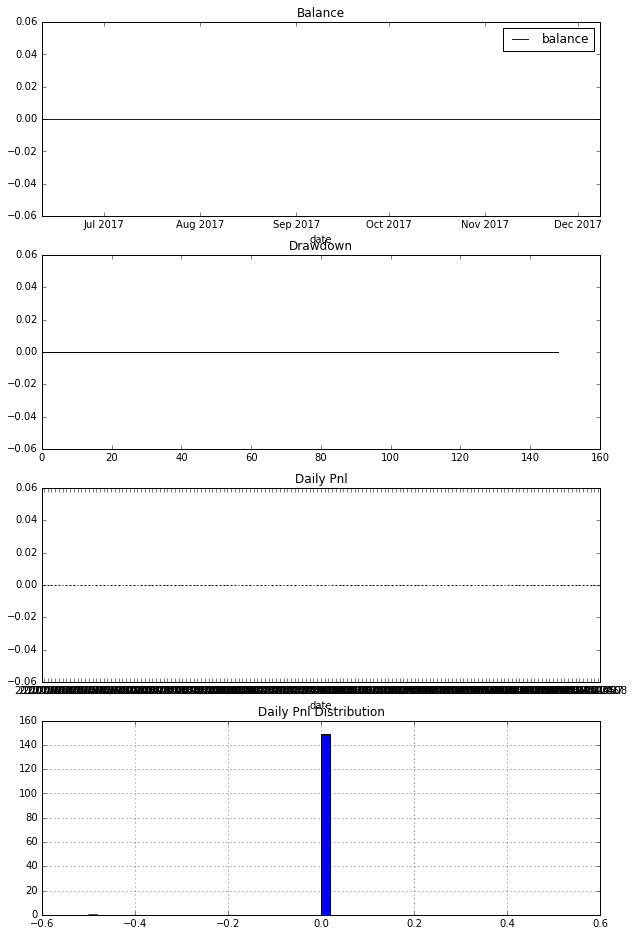

In [6]:
'''
回测
'''

#创建回测引擎实例
engine = BacktestingEngine()

#设置引擎的回测模式为K线
engine.setBacktestingMode(engine.TICK_MODE)

#设置回测的起始日期
engine.setStartDate(startDate, initDays = TestStrategy.initDays) #这里的initDays是真正起作用的

#设置产品相关参数
engine.setSlippage(0)           #滑点设置为0
engine.setRate(1.0/10000)       #合约交易手续费万1
engine.setSize(10)               #合约每手数量
engine.setPriceTick(1)      #合约最小价格变动
engine.setCapital(0) #初始资金

#设置使用的数据库
engine.setDatabase(TICK_DB_NAME, vtCode)

#引擎中创建策略对象
engine.initStrategy(TestStrategy, {})

#开始跑回测
engine.runBacktesting()

#显示回测结果
engine.showDailyResult()